# Linear Models

In [22]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers


In [65]:
conn = sqlite3.connect('/Users/eerichmo/Documents/fires.sqlite')
cur = conn.cursor()

df_fires = pd.read_sql_query("""
select
	weather_county.fips,
	weather_county.month,
	weather_county.date,
	weather_county.year,
	weather_county.precipitation,
	weather_county.pressure,
	weather_county.humidity_2m,
	weather_county.temp_2m,
	weather_county.temp_dew_point_2m,
	weather_county.temp_wet_bulb_2m,
	weather_county.temp_max_2m,
	weather_county.temp_min_2m,
	weather_county.temp_range_2m,
	weather_county.temp_0m,
	weather_county.wind_10m,
	weather_county.wind_max_10m,
	weather_county.wind_min_10m,
	weather_county.wind_range_10m,
	weather_county.wind_50m,
	weather_county.wind_max_50m,
	weather_county.wind_min_50m,
	weather_county.wind_range_50m,
	weather_county.drought_score,
	soil.elevation,
	soil.slope_005,
	soil.slope_005_02,
	soil.slope_02_05,
	soil.slope_05_10,
	soil.slope_10_15,
	soil.slope_15_30,
	soil.slope_30_45,
	soil.slope_45,
	soil.aspect_north,
	soil.aspect_east,
	soil.aspect_south,
	soil.aspect_west,
	soil.aspect_unknown,
	soil.water_land,
	soil.barren_land,
	soil.urban_land,
	soil.grass_land,
	soil.forest_land,
	soil.partial_cultivated_land,
	soil.irrigated_land,
	soil.cultivated_land,
	soil.nutrient,
	soil.nutrient_retention,
	soil.rooting,
	soil.oxygen,
	soil.excess_salts,
	soil.toxicity,
	soil.workablity,

	ifnull(fires.fire_size, 0) as fire_size,
  ifnull(fires.fire_size_class, '') as fire_size_class
from weather_county
inner join soil
left outer join (
	select max(fire_size) as fire_size, max(fire_size_class) as fire_size_class, fips, date
	from fires
	where
		cause_descr in (
			'Miscellaneous', 'Lightning', 'Powerline', 'Missing/Undefined', 'Debris Buring', 'Campfire'
		)
	group by fips, date
) as fires on
  fires.fips = weather_county.fips
  and fires.date = weather_county.date
where
  soil.fips = weather_county.fips
	and soil.fips != 6065
	and weather_county.month in (8, 9, 10, 11)
""", conn)

# Ignoring FIPS = 6065, Riverside, since it has a disproportionate number of 'Miscellaneous' fires 

# TODO: try joining on a week date range in case the fire discovery date was late

print(df_fires.columns)

conn.close()

Index(['fips', 'month', 'date', 'year', 'precipitation', 'pressure',
       'humidity_2m', 'temp_2m', 'temp_dew_point_2m', 'temp_wet_bulb_2m',
       'temp_max_2m', 'temp_min_2m', 'temp_range_2m', 'temp_0m', 'wind_10m',
       'wind_max_10m', 'wind_min_10m', 'wind_range_10m', 'wind_50m',
       'wind_max_50m', 'wind_min_50m', 'wind_range_50m', 'drought_score',
       'elevation', 'slope_005', 'slope_005_02', 'slope_02_05', 'slope_05_10',
       'slope_10_15', 'slope_15_30', 'slope_30_45', 'slope_45', 'aspect_north',
       'aspect_east', 'aspect_south', 'aspect_west', 'aspect_unknown',
       'water_land', 'barren_land', 'urban_land', 'grass_land', 'forest_land',
       'partial_cultivated_land', 'irrigated_land', 'cultivated_land',
       'nutrient', 'nutrient_retention', 'rooting', 'oxygen', 'excess_salts',
       'toxicity', 'workablity', 'fire_size', 'fire_size_class'],
      dtype='object')


In [66]:
from datetime import datetime

df_fires.date = pd.to_datetime(df_fires.date)
df_fires['day_of_week'] = df_fires.date.dt.dayofweek

print(df_fires.info())

X_trim = df_fires.drop(['date', 'fire_size', 'fire_size_class'], axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111264 entries, 0 to 111263
Data columns (total 55 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   fips                     111264 non-null  int64         
 1   month                    111264 non-null  int64         
 2   date                     111264 non-null  datetime64[ns]
 3   year                     111264 non-null  int64         
 4   precipitation            111264 non-null  float64       
 5   pressure                 111264 non-null  float64       
 6   humidity_2m              111264 non-null  float64       
 7   temp_2m                  111264 non-null  float64       
 8   temp_dew_point_2m        111264 non-null  float64       
 9   temp_wet_bulb_2m         111264 non-null  float64       
 10  temp_max_2m              111264 non-null  float64       
 11  temp_min_2m              111264 non-null  float64       
 12  temp_range_2m   

<AxesSubplot:>

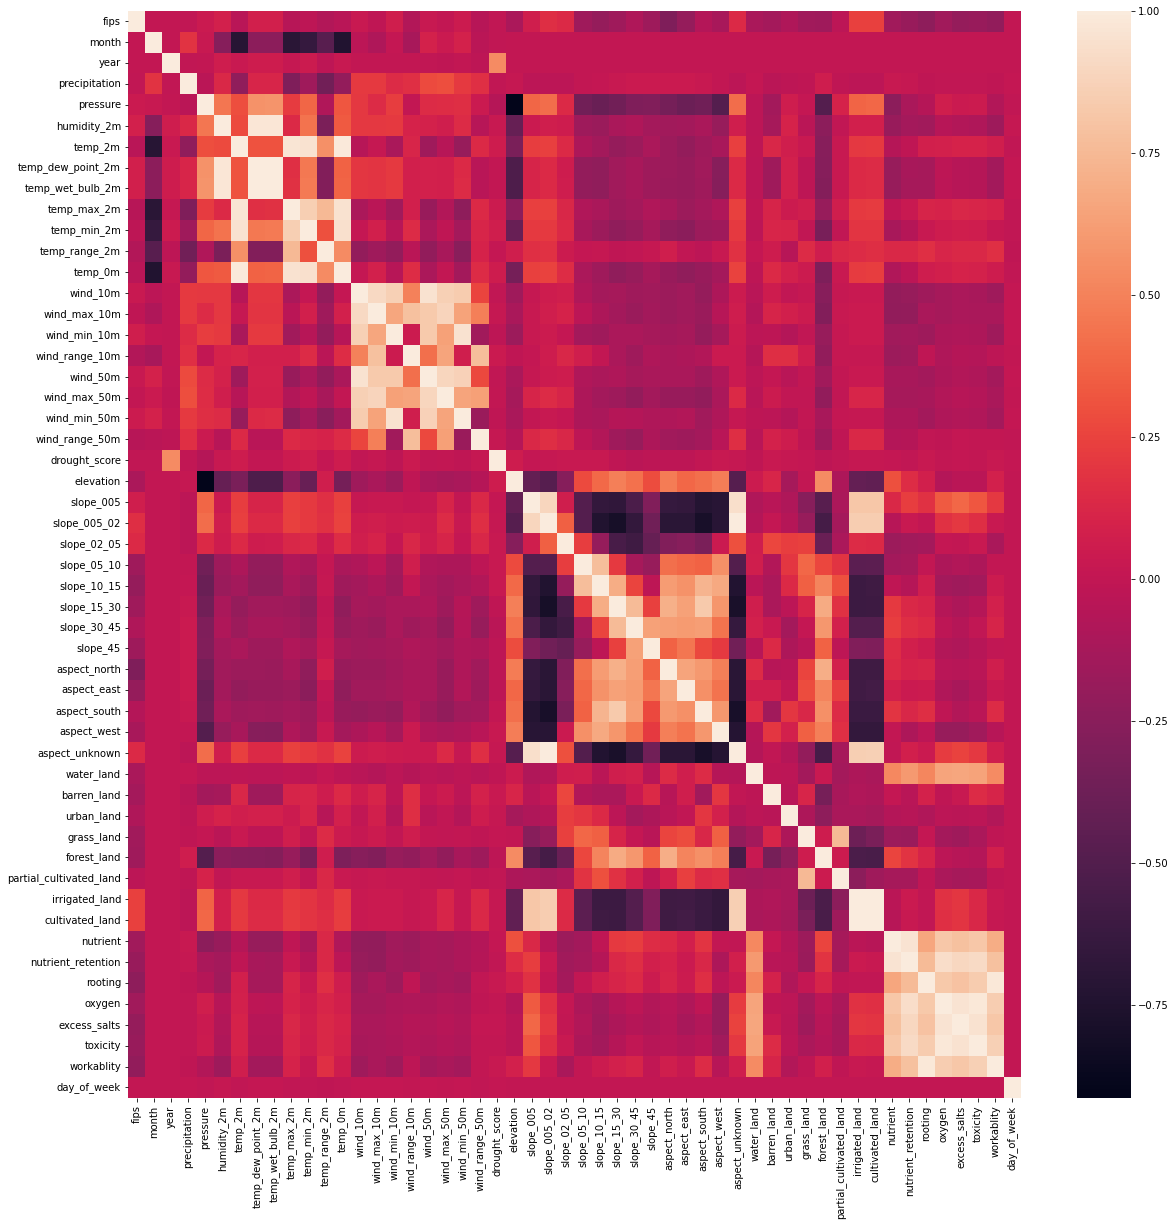

In [67]:
plt.figure(figsize=(20, 20))
sns.heatmap(X_trim.corr())

In [76]:
X_encoded = pd.get_dummies(X_trim, columns=['fips', 'day_of_week', 'year', 'month'])

scaler = StandardScaler()
scaler.fit(X_encoded)
X = scaler.transform(X_encoded)

y = (df_fires.fire_size_class != '').values
# y = (df_fires.fire_size_class > 'A').values # Ignore small fires ('' or 'A') for now

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

params={
  'C': [0.1, 1],
  'class_weight':[{True: w} for w in [1, 2, 4, 6, 10]]
}

log_reg = LogisticRegression(solver='liblinear', max_iter=1000)
log_reg = GridSearchCV(estimator=log_reg, param_grid=params, scoring='recall', cv=5)

log_reg.fit(X, y)

print(f'Estimator', log_reg.best_estimator_)

Estimator LogisticRegression(C=0.1, class_weight={True: 1}, max_iter=1000,
                   solver='liblinear')


In [77]:
num_fires = (y == 1).sum()
num_data_pt = len(y)
print(f'{num_fires} non-small fires out of {len(y)} data points')
print(f'No fires {1 - round(num_fires/num_data_pt, 2)}% of the time')

print('--------- Log Regression Accuracy ---------')
print(accuracy_score(log_reg.predict(X_test), y_test))

y_pred_log_reg = log_reg.predict(X_train)

print('--------- Log Regression Classification ---------')
print(classification_report(y_train, y_pred_log_reg))

16823 non-small fires out of 111264 data points
No fires 0.85% of the time
--------- Log Regression Accuracy ---------
0.8523152142651711
--------- Log Regression Classification ---------
              precision    recall  f1-score   support

       False       0.86      0.98      0.92     70824
        True       0.55      0.12      0.20     12624

    accuracy                           0.85     83448
   macro avg       0.71      0.55      0.56     83448
weighted avg       0.81      0.85      0.81     83448



In [75]:
from sklearn.ensemble import RandomForestClassifier

params = {
  'n_estimators': np.arange(40, 120, 20),
  # 'splitter': ['best', 'random'],
  'max_features': np.arange(2, 15, 1),
  'max_depth': np.arange(10, 20, 1),
  'min_samples_split': np.arange(2, 10, 1),
  'min_samples_leaf': np.arange(1, 10, 1),
  'max_leaf_nodes': np.arange(5, 15, 1),
  'class_weight':[{True: w} for w in [1, 2, 4, 6, 10]]
}

rand_forest = RandomizedSearchCV(RandomForestClassifier(), params, scoring="recall")
rand_forest.fit(X_train, y_train)

print(f'Best Params', rand_forest.best_params_)
print(f'Best Score', rand_forest.best_score_)

print('--------- RandomForestClassifier Classification ---------')
y_pred_rand_forest = rand_forest.predict(X_test)
print(classification_report(y_test, y_pred_rand_forest))

Best Params {'n_estimators': 40, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_leaf_nodes': 10, 'max_features': 2, 'max_depth': 16, 'class_weight': {True: 10}}
Best Score 0.9885139727918908
--------- RandomForestClassifier Classification ---------
              precision    recall  f1-score   support

       False       0.99      0.08      0.15     23617
        True       0.16      1.00      0.28      4199

    accuracy                           0.22     27816
   macro avg       0.58      0.54      0.22     27816
weighted avg       0.87      0.22      0.17     27816



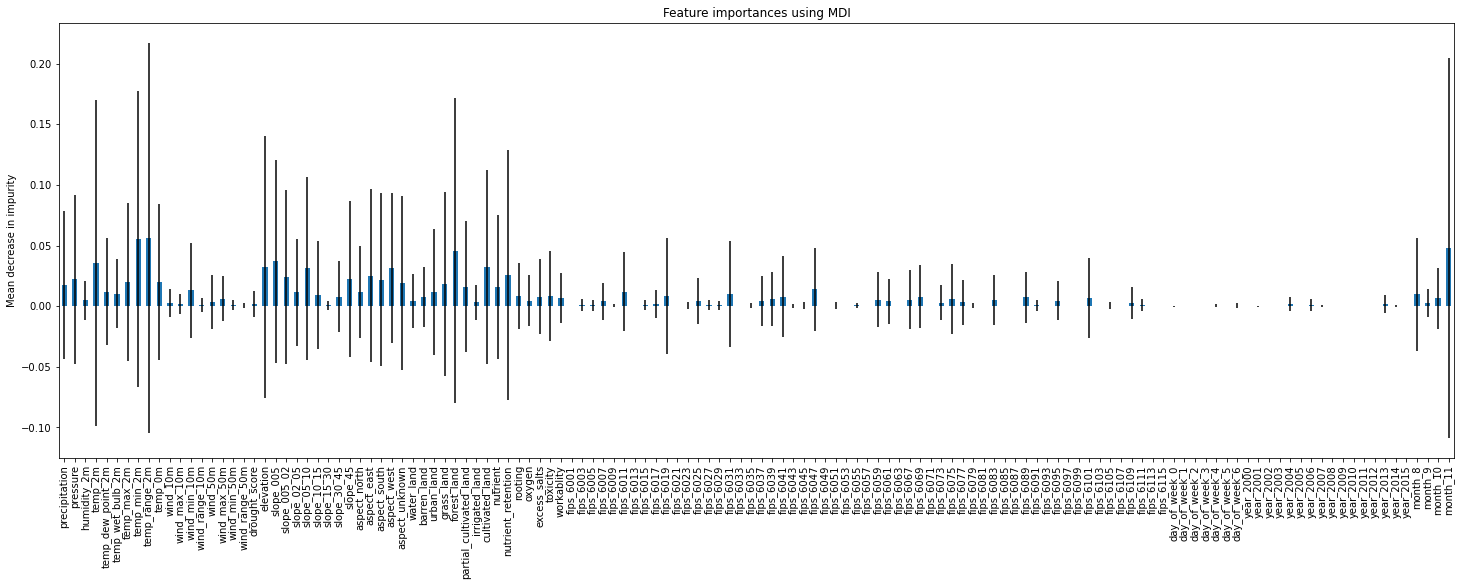

In [78]:
importances = rand_forest.best_estimator_.feature_importances_
forest_importances = pd.Series(importances, index=X_encoded.columns.values)
std = np.std([tree.feature_importances_ for tree in rand_forest.best_estimator_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title('Feature importances using MDI')
ax.set_ylabel('Mean decrease in impurity')
fig.set_figheight(8)
fig.set_figwidth(25)

In [304]:
import xgboost as xgb

params={
  'objective': ['binary:logistic'],
  'max_depth': [3, 4, 5],
  'gamma':[0.5, 1, 5],
  'subsample': [0.5],
  'colsample_bytree': [0.1],
  'colsample_bylevel': [1.0],
  'learning_rate': [0.1],
  'n_estimators': [500, 600],
  'eval_metric': ['logloss']
}

xgb_clf = xgb.XGBClassifier(seed=42, use_label_encoder=False)

xgb_clf = RandomizedSearchCV(estimator=xgb_clf, param_distributions=params)

xgb_clf.fit(X_train, y_train)

print("Best Params:", xgb_clf.best_params_)

# Best Params: {'subsample': 0.5, 'objective': 'binary:logistic', 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 5, 'eval_metric': 'logloss', 'colsample_bytree': 0.1, 'colsample_bylevel': 0.9}

Best Params: {'subsample': 0.5, 'objective': 'binary:logistic', 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 5, 'eval_metric': 'logloss', 'colsample_bytree': 0.1, 'colsample_bylevel': 1.0}


In [305]:
y_pred_xgb = xgb_clf.predict(X_test)

print('--------- XGBoost Classification Report ---------')
print(classification_report(y_test, y_pred_xgb))

--------- XGBoost Classification Report ---------
              precision    recall  f1-score   support

       False       0.92      1.00      0.96     26117
        True       0.65      0.03      0.06      2187

    accuracy                           0.92     28304
   macro avg       0.79      0.52      0.51     28304
weighted avg       0.90      0.92      0.89     28304



In [30]:
precip = np.array(X_encoded.precipitation)

precip_normalizer = layers.Normalization(input_shape=[1,], axis=None)
precip_normalizer.adapt(precip)

In [31]:
precip_model = tf.keras.Sequential([
    precip_normalizer,
    layers.Dense(units=1)
])

precip_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [32]:
precip_model.predict(precip[:10])

array([[-0.06801032],
       [-0.06801032],
       [-0.06801032],
       [-0.06724043],
       [-0.06801032],
       [-0.06724043],
       [-0.06724043],
       [-0.06724043],
       [-0.05954143],
       [-0.06416083]], dtype=float32)

In [33]:
precip_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [36]:
%%time
history = precip_model.fit(
    X_encoded.precipitation,
    y,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 2min 48s, sys: 20.9 s, total: 3min 9s
Wall time: 2min 15s


        loss  val_loss  epoch
95  0.180354  0.140571     95
96  0.182100  0.161350     96
97  0.181071  0.144636     97
98  0.180376  0.142445     98
99  0.180997  0.147473     99


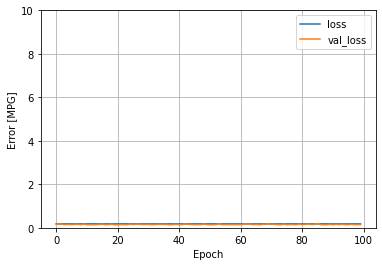

In [37]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print(hist.tail())

plot_loss(history)

In [60]:
x_precip = tf.linspace(0, 110, 111)
y_precip = np.concatenate(precip_model.predict(x_precip)).ravel()

print(x_precip.shape)
print(y_precip.shape)

(111,)
(111,)


(113216,)
(84912,)


ValueError: x and y must be the same size

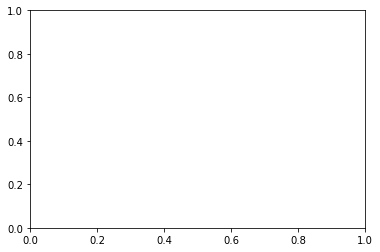

In [63]:
def plot_precip(x_plot, y_plot):
  print(X_encoded.precipitation.shape)
  print(y_train.shape) 
  plt.scatter(X_encoded.precipitation, y_train, label='Data')
  plt.plot(x_plot, y_plot, color='k', label='Predictions')
  plt.xlabel('Precipitation')
  plt.ylabel('Fire')
  plt.legend()

plot_precip(x_precip, y_precip)